# Introduction

The goal of this project is to create a small and simple language model on music data from spotify that completes a sentence using lyrics data. Even though this model does not bring any value to the music industry, it will be a fun little model to complete sentences of songwriters who struggle to finsih a sentence while writing songs. This strategy will be based on predictive models using a machine learning algorithm and tensorflow.

To do this we use several datasets from Kaggle: 

https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset

https://www.kaggle.com/datasets/notshrirang/spotify-million-song-dataset

https://www.kaggle.com/datasets/nelgiriyewithana/top-spotify-songs-2023/data

The datasets are mostly composed of lyrics, artists, genres, title, etc. but have other properties as well that add too much complexity and are therefore left out in this project. I chose to start these datasets because, combined, they can add more value to an overall more clean dataset.

### Install Tensorflow : pip install tensorflow

### Imports

In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Dataset clean up

In [2]:
# https://www.kaggle.com/datasets/nelgiriyewithana/top-spotify-songs-2023/data
most_streamed = pd.read_csv('spotify-most-streamed-2023.csv', encoding='ISO-8859-1')
# https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset
lyrics = pd.read_csv('spotify-lyrics.csv', encoding='ISO-8859-1')
# https://www.kaggle.com/datasets/notshrirang/spotify-million-song-dataset
songs = pd.read_csv('songs.csv', encoding='ISO-8859-1')

In [3]:
most_streamed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            953 non-null    object
 1   artist(s)_name        953 non-null    object
 2   artist_count          953 non-null    int64 
 3   released_year         953 non-null    int64 
 4   released_month        953 non-null    int64 
 5   released_day          953 non-null    int64 
 6   in_spotify_playlists  953 non-null    int64 
 7   in_spotify_charts     953 non-null    int64 
 8   streams               953 non-null    object
 9   in_apple_playlists    953 non-null    int64 
 10  in_apple_charts       953 non-null    int64 
 11  in_deezer_playlists   953 non-null    object
 12  in_deezer_charts      953 non-null    int64 
 13  in_shazam_charts      903 non-null    object
 14  bpm                   953 non-null    int64 
 15  key                   858 non-null    ob

In [45]:
lyrics.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44795 entries, 0 to 57644
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   song    44795 non-null  object
 1   text    44795 non-null  object
dtypes: object(2)
memory usage: 1.0+ MB


In [57]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89741 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        89741 non-null  int64  
 1   track_id          89741 non-null  object 
 2   artists           89740 non-null  object 
 3   album_name        89740 non-null  object 
 4   track_name        89740 non-null  object 
 5   popularity        89741 non-null  int64  
 6   duration_ms       89741 non-null  int64  
 7   explicit          89741 non-null  bool   
 8   danceability      89741 non-null  float64
 9   energy            89741 non-null  float64
 10  key               89741 non-null  int64  
 11  loudness          89741 non-null  float64
 12  mode              89741 non-null  int64  
 13  speechiness       89741 non-null  float64
 14  acousticness      89741 non-null  float64
 15  instrumentalness  89741 non-null  float64
 16  liveness          89741 non-null  float64
 1

### Dropping duplicate rows
There are several rows that are basically identical but have a difference in an irrelevant column.
There are also remixes, covers, etc. of songs that have the exact same lyrics. I take the first unique lyrics in that case.

In [4]:
songs = songs.drop_duplicates(subset='track_id', keep='first')

In [5]:
songs = songs.drop_duplicates(subset='track_name', keep='first')

In [6]:
columns_to_remove = ['artist', 'link']
lyrics = lyrics.drop(columns=columns_to_remove)
lyrics = lyrics.drop_duplicates(subset='song', keep='first')
lyrics = lyrics.drop_duplicates(subset='text', keep='first')

In [7]:
lyrics.head(50)

,song,text
0,Ahe's My Kind Of Girl,"Look at her face, it's a wonderful face \r\nA..."
1,"Andante, Andante","Take it easy with me, please \r\nTouch me gen..."
2,As Good As New,I'll never know why I had to go \r\nWhy I had...
3,Bang,Making somebody happy is a question of give an...
4,Bang-A-Boomerang,Making somebody happy is a question of give an...
5,Burning My Bridges,"Well, you hoot and you holler and you make me ..."
6,Cassandra,Down in the street they're all singing and sho...
7,Chiquitita,"Chiquitita, tell me what's wrong \r\nYou're e..."
8,Crazy World,I was out with the morning sun \r\nCouldn't s...
9,Crying Over You,I'm waitin' for you baby \r\nI'm sitting all ...


### Merging relevant datasets Most streamed songs & Lyrics only
text = lyrics

#### 1st cleaned up dataset: Most Streamed + Lyrics

In [8]:
most_streamed_and_lyrics = pd.merge(most_streamed,lyrics, left_on='track_name', right_on='song')

In [9]:
most_streamed_and_lyrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            165 non-null    object
 1   artist(s)_name        165 non-null    object
 2   artist_count          165 non-null    int64 
 3   released_year         165 non-null    int64 
 4   released_month        165 non-null    int64 
 5   released_day          165 non-null    int64 
 6   in_spotify_playlists  165 non-null    int64 
 7   in_spotify_charts     165 non-null    int64 
 8   streams               165 non-null    object
 9   in_apple_playlists    165 non-null    int64 
 10  in_apple_charts       165 non-null    int64 
 11  in_deezer_playlists   165 non-null    object
 12  in_deezer_charts      165 non-null    int64 
 13  in_shazam_charts      152 non-null    object
 14  bpm                   165 non-null    int64 
 15  key                   153 non-null    ob

#### 2nd cleaned up dataset: All Songs + Lyrics

In [10]:
all_songs_and_lyrics = pd.merge(songs,lyrics, left_on='track_name', right_on='song', suffixes=('', ''))

In [11]:
all_songs_and_lyrics = all_songs_and_lyrics.drop(columns=['song'])

In [12]:
all_songs_and_lyrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531 entries, 0 to 5530
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        5531 non-null   int64  
 1   track_id          5531 non-null   object 
 2   artists           5531 non-null   object 
 3   album_name        5531 non-null   object 
 4   track_name        5531 non-null   object 
 5   popularity        5531 non-null   int64  
 6   duration_ms       5531 non-null   int64  
 7   explicit          5531 non-null   bool   
 8   danceability      5531 non-null   float64
 9   energy            5531 non-null   float64
 10  key               5531 non-null   int64  
 11  loudness          5531 non-null   float64
 12  mode              5531 non-null   int64  
 13  speechiness       5531 non-null   float64
 14  acousticness      5531 non-null   float64
 15  instrumentalness  5531 non-null   float64
 16  liveness          5531 non-null   float64


### Saving the cleaned up relevant datasets into new csv files

In [13]:
all_songs_and_lyrics.to_csv('all_songs_and_lyrics.csv', index=False)

In [14]:
most_streamed_and_lyrics.to_csv('most_streamed_and_lyrics.csv', index=False)

# Create own Text Generation Model using Tensorflow
### Training the model with our song data primarily focusing on lyrics

In [14]:
# Load the dataset
data = pd.read_csv('all_songs_and_lyrics.csv')

# Extract lyrics and numerical features
lyrics = data['text']
numerical_features = data[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']]

# Clean and preprocess lyrics
def preprocess_lyrics(lyric):
    # Lowercase the lyric
    lyric = lyric.lower()

    # Remove punctuation
    lyric = re.sub(r'[^\w\s]', '', lyric)

    # Remove extra whitespaces
    lyric = re.sub(r'\s+', ' ', lyric)

    # Return the preprocessed lyric
    return lyric

preprocessed_lyrics = [preprocess_lyrics(lyric) for lyric in lyrics]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(preprocessed_lyrics)
sequences = tokenizer.texts_to_sequences(preprocessed_lyrics)
total_words = len(tokenizer.word_index) + 1
max_sequence_length = max(len(seq) for seq in tokenizer.texts_to_sequences(data['text']))

padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')

input_sequences = []
for sequence in sequences:
    for i in range(1, len(sequence)):
        n_gram_sequence = sequence[:i+1]
        input_sequences.append(n_gram_sequence)

input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='pre')

X = input_sequences[:, :-1]
y = input_sequences[:, -1]

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(total_words, 64, input_length=max_sequence_length-1),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dense(total_words, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=1, verbose=1)

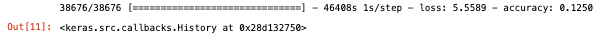

#### This model ran for about 10 hours on my 16GB RAM Macbook pro

### Save model for futures usages

In [ ]:
new_model = tf.keras.models.load_model('my_first_shit.keras')

### Testing the model with a simple text input

In [ ]:
seed_text = "How do I"
next_words = 10

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_length-1, padding='pre')
    predict_x = model.predict(token_list, verbose=0) 
    classes_x = np.argmax(predict_x,axis=1)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == classes_x:
            output_word = word
            break
    seed_text += " " + output_word

print(seed_text)

In [ ]:
# Show the model architecture
new_model.summary()

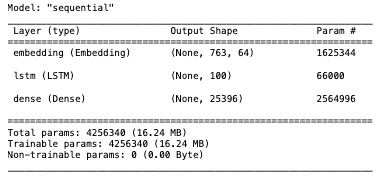

In [1]:
from tensorflow.keras.models import load_model

In [2]:
# Load the model
model = load_model('my_first_shit.keras')

# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 763, 64)           1625344   
                                                                 
 lstm (LSTM)                 (None, 100)               66000     
                                                                 
 dense (Dense)               (None, 25396)             2564996   
                                                                 
Total params: 4256340 (16.24 MB)
Trainable params: 4256340 (16.24 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
def completeSentenceUsingNWords(seed_text, next_words):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_length-1, padding='pre')
        predict_x = model.predict(token_list, verbose=0) 
        classes_x = np.argmax(predict_x,axis=1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == classes_x:
                output_word = word
                break
        seed_text += " " + output_word
    print(seed_text)
    return seed_text

In [20]:
completeSentenceUsingNWords('I should have bought you', 8)

I should have bought you to the sea of the world i was


'I should have bought you to the sea of the world i was'

In [25]:
completeSentenceUsingNWords('When I think of You, the world', 3)

When I think of You, the world is the one


'When I think of You, the world is the one'

In [26]:
completeSentenceUsingNWords('In the middle of the night', 3)

In the middle of the night i can see


'In the middle of the night i can see'

In [35]:
completeSentenceUsingNWords('Through my Heart break, I learned', 8)

Through my Heart break, I learned to be the one who i could be


'Through my Heart break, I learned to be the one who i could be'

In [37]:
completeSentenceUsingNWords('I hear you talking in', 5)

I hear you talking in the middle of the night


'I hear you talking in the middle of the night'

In [38]:
completeSentenceUsingNWords('Is there something on', 5)

Is there something on the ground and the sun


'Is there something on the ground and the sun'

In [43]:
completeSentenceUsingNWords('She likes boys', 10)

She likes boys and i know i was a little bit of her


'She likes boys and i know i was a little bit of her'

## This project can be further developed using the other properties of the datasets, and, of course, fine tuning and multiple training rounds. For now, the model completes basic sentences